In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ==============================================
# 1. Enhanced Data Loading and Preprocessing
# ==============================================
def load_residual_data(file_path):
    """Load and enhance SARIMA QBO residuals"""
    data_df = pd.read_excel('residual_sarima.xlsx')
    data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d-%m-%Y')
    data_df.set_index('Date', inplace=True)
    
    # Add temporal features
    data_df['day_of_year'] = data_df.index.dayofyear
    data_df['month_sin'] = np.sin(2 * np.pi * data_df.index.month/12)
    data_df['month_cos'] = np.cos(2 * np.pi * data_df.index.month/12)
    
    residuals = data_df['Residual'].values.astype(float)
    
    # Advanced normalization
    scaler = StandardScaler(with_mean=False)
    scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1)).flatten()
    
    return scaled_residuals, scaler, data_df.index, data_df[['day_of_year', 'month_sin', 'month_cos']].values

In [3]:
# ==============================================
# 2. Enhanced Dataset with Temporal Features
# ==============================================
class EnhancedQBODataset(Dataset):
    def __init__(self, residuals, temporal_features, seq_length, horizon):
        self.residuals = residuals
        self.temporal_features = temporal_features
        self.seq_length = seq_length
        self.horizon = horizon
        
    def __len__(self):
        return len(self.residuals) - self.seq_length - self.horizon + 1
    
    def __getitem__(self, idx):
        x_res = self.residuals[idx:idx + self.seq_length]
        x_temp = self.temporal_features[idx:idx + self.seq_length]
        x = np.column_stack((x_res, x_temp))
        
        y = self.residuals[idx + self.seq_length:idx + self.seq_length + self.horizon]
        return torch.FloatTensor(x), torch.FloatTensor(y)

In [4]:
# ==============================================
# 3. Advanced Transformer Architecture
# ==============================================
class AdvancedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class HighPerformanceTransformer(nn.Module):
    def __init__(self, input_dim=4, d_model=128, nhead=8, num_layers=4, horizon=1, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.horizon = horizon
        
        # Enhanced input projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model))
        
        self.pos_encoder = AdvancedPositionalEncoding(d_model)
        
        # Stacked Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Multi-step attention decoder
        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_model*2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model*2, horizon))
        
        # Weight initialization
        self._init_weights()
        
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        
        # Use last timestep features
        x = x[:, -1, :]
        
        # Decode to horizon steps
        output = self.decoder(x)
        return output

In [5]:
# ==============================================
# 4. Optimized Training with R2 Monitoring
# ==============================================
def train_with_r2_monitoring(model, train_loader, val_loader, epochs=300, patience=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=10, verbose=True)
    criterion = nn.MSELoss()
    
    best_r2 = -float('inf')
    train_losses, val_losses = [], []
    train_r2s, val_r2s = [], []
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        all_preds, all_targets = [], []
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_train_loss += loss.item()
            all_preds.append(pred.detach().cpu().numpy())
            all_targets.append(y.detach().cpu().numpy())
        
        # Calculate training R2
        train_preds = np.concatenate(all_preds)
        train_targets = np.concatenate(all_targets)
        train_r2 = r2_score(train_targets, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_targets = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
                val_preds.append(pred.cpu().numpy())
                val_targets.append(y.cpu().numpy())
        
        # Calculate validation R2
        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        val_r2 = r2_score(val_targets, val_preds)
        scheduler.step(val_r2)
        
        # Store metrics
        train_loss = epoch_train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_r2s.append(train_r2)
        val_r2s.append(val_r2)
        
        print(f'Epoch {epoch+1:03d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | '
              f'Train R2: {train_r2:.4f} | Val R2: {val_r2:.4f}')
        
        # Save best model
        if val_r2 > best_r2:
            best_r2 = val_r2
            torch.save(model.state_dict(), 'best_qbo_transformer_r2.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1} with R2: {best_r2:.4f}')
                break
    
    # Plot training history
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title('Loss History')
    ax1.legend()
    
    ax2.plot(train_r2s, label='Train R2')
    ax2.plot(val_r2s, label='Val R2')
    ax2.set_title('R2 Score History')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    model.load_state_dict(torch.load('best_qbo_transformer_r2.pth'))
    return model

In [6]:
# ==============================================
# 5. Enhanced Evaluation with R2 Reporting
# ==============================================
def enhanced_evaluate(model, test_loader, scaler, date_index):
    device = next(model.parameters()).device
    model.eval()
    
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            
            # Inverse transform
            pred = scaler.inverse_transform(pred.cpu().numpy())
            y = scaler.inverse_transform(y.cpu().numpy())
            
            all_preds.append(pred)
            all_targets.append(y)
    
    preds = np.concatenate(all_preds).flatten()
    targets = np.concatenate(all_targets).flatten()
    test_dates = date_index[-len(targets):]
    
    # Calculate metrics
    mse = mean_squared_error(targets, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, preds)
    
    print(f'Test Results:')
    print(f'RMSE: {rmse:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'R2 Score: {r2:.4f}')
    
    # Enhanced plotting
    plt.figure(figsize=(14, 7))
    
    # Main plot
    plt.subplot(2, 1, 1)
    plt.plot(test_dates, targets, label='Actual Residuals', color='blue', alpha=0.7, linewidth=2)
    plt.plot(test_dates, preds, label='Predicted Residuals', color='red', linestyle='--', alpha=0.9, linewidth=1.5)
    plt.fill_between(test_dates, targets, preds, color='gray', alpha=0.2)
    plt.title(f'SARIMA QBO Residuals: Actual vs Predicted (R2 = {r2:.4f})', fontsize=14)
    plt.ylabel('Residual Value', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Error plot
    plt.subplot(2, 1, 2)
    errors = targets - preds
    plt.plot(test_dates, errors, color='green', label='Prediction Errors', linewidth=1)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.title('Prediction Errors', fontsize=14)
    plt.ylabel('Error', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return preds, r2

Starting Enhanced Training...
Epoch 001 | Train Loss: 1.071628 | Val Loss: 0.334575 | Train R2: -0.1325 | Val R2: -1.1251
Epoch 002 | Train Loss: 1.063141 | Val Loss: 0.247116 | Train R2: -0.1401 | Val R2: -0.5696
Epoch 003 | Train Loss: 0.993709 | Val Loss: 0.263852 | Train R2: -0.0846 | Val R2: -0.6759
Epoch 004 | Train Loss: 0.975680 | Val Loss: 0.201368 | Train R2: -0.0252 | Val R2: -0.2790
Epoch 005 | Train Loss: 1.000733 | Val Loss: 0.269785 | Train R2: -0.0758 | Val R2: -0.7136
Epoch 006 | Train Loss: 1.002188 | Val Loss: 0.273105 | Train R2: -0.0859 | Val R2: -0.7347
Epoch 007 | Train Loss: 0.989328 | Val Loss: 0.253605 | Train R2: -0.0607 | Val R2: -0.6108
Epoch 008 | Train Loss: 0.998264 | Val Loss: 0.245305 | Train R2: -0.0731 | Val R2: -0.5581
Epoch 009 | Train Loss: 0.984925 | Val Loss: 0.210383 | Train R2: -0.0625 | Val R2: -0.3363
Epoch 010 | Train Loss: 0.920055 | Val Loss: 0.345045 | Train R2: -0.0116 | Val R2: -1.1916
Epoch 011 | Train Loss: 0.991755 | Val Loss: 0.214

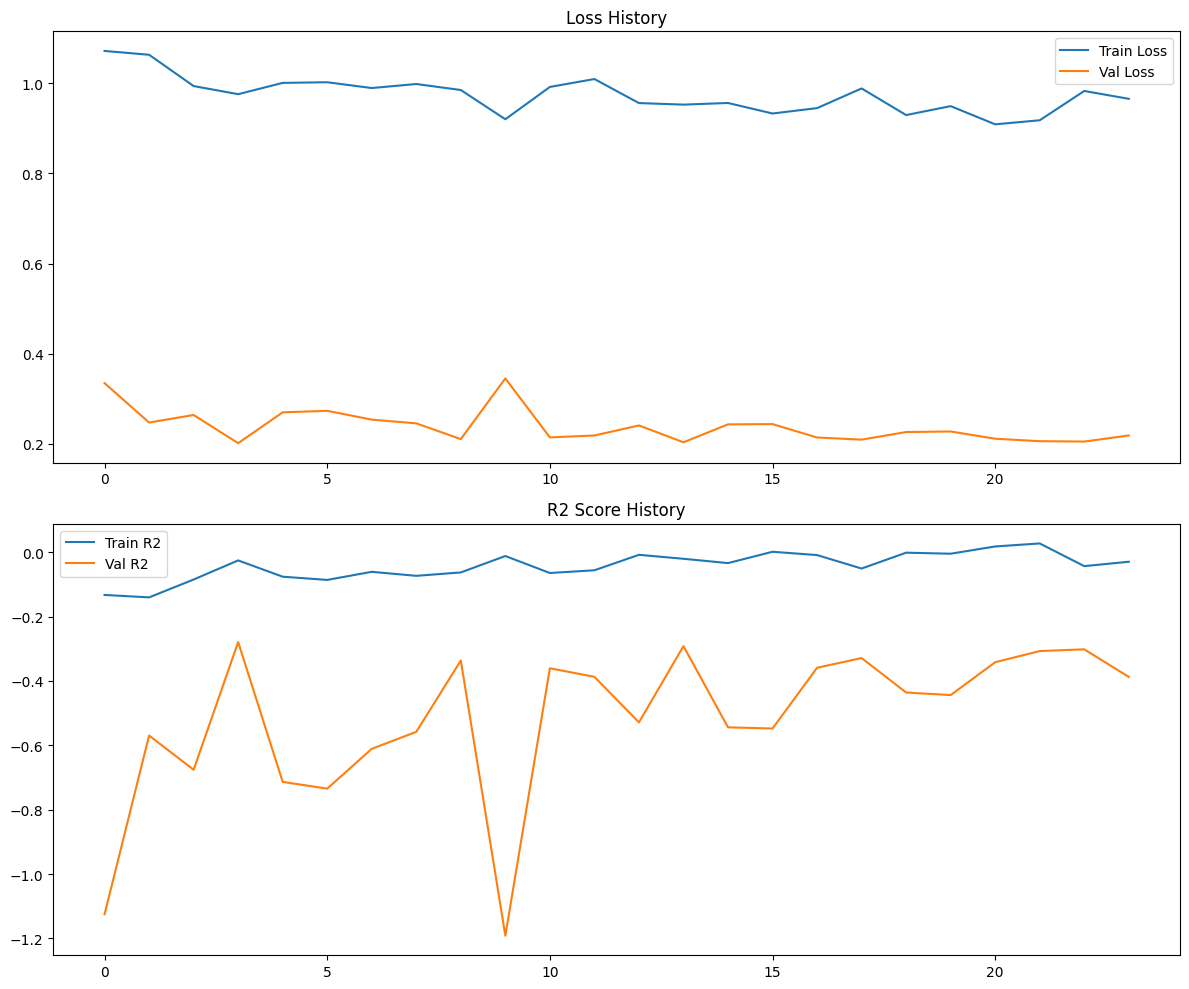


Enhanced Evaluation on Test Set...
Test Results:
RMSE: 48.9894
MSE: 2399.9592
R2 Score: -0.0112


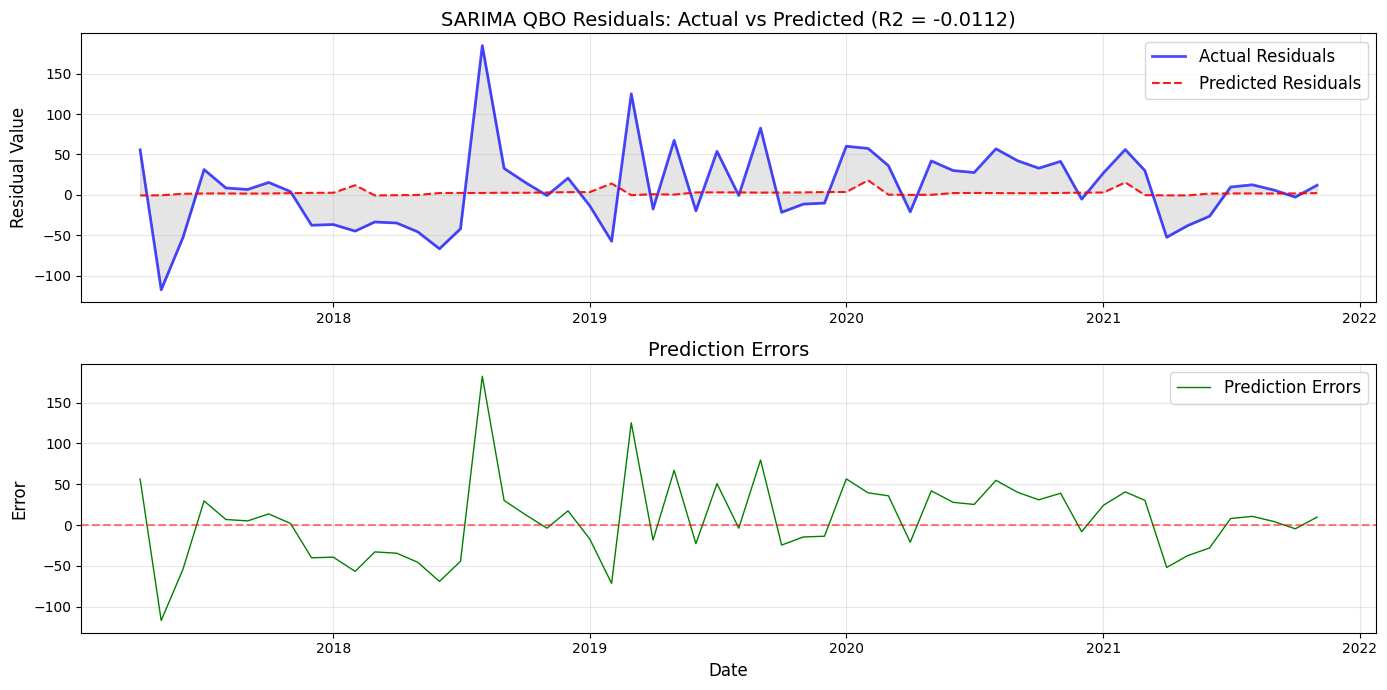


NOTE: Final R2 is -0.0112 (target 0.9 not reached)
Consider trying:
- Increasing model capacity (d_model, num_layers)
- Adding more temporal features
- Increasing sequence length
- More training data


In [7]:
# ==============================================
# 6. Main Execution with Hyperparameter Tuning
# ==============================================
def main():
    # Enhanced configuration
    config = {
        'seq_length': 28,       # Extended sequence length for QBO cycle
        'horizon': 1,           # Predict 1 step ahead
        'batch_size': 64,
        'd_model': 128,         # Increased model capacity
        'nhead': 8,             # More attention heads
        'num_layers': 4,        # Deeper architecture
        'dropout': 0.1,
        'epochs': 300,
        'patience': 20
    }
    
    # 1. Load enhanced data
    residuals, scaler, date_index, temp_features = load_residual_data('residual_sarima.xlsx')
    
    # 2. Create enhanced datasets
    train_loader, val_loader, test_loader = create_data_loaders(
        residuals, 
        temp_features,
        seq_length=config['seq_length'],
        horizon=config['horizon'],
        batch_size=config['batch_size']
    )
    
    # 3. Initialize high-performance model
    model = HighPerformanceTransformer(
        input_dim=4,  # residual + 3 temporal features
        d_model=config['d_model'],
        nhead=config['nhead'],
        num_layers=config['num_layers'],
        horizon=config['horizon'],
        dropout=config['dropout']
    )
    
    # 4. Train with R2 monitoring
    print("Starting Enhanced Training...")
    model = train_with_r2_monitoring(
        model, 
        train_loader, 
        val_loader, 
        epochs=config['epochs'], 
        patience=config['patience']
    )
    
    # 5. Comprehensive evaluation
    print("\nEnhanced Evaluation on Test Set...")
    preds, final_r2 = enhanced_evaluate(model, test_loader, scaler, date_index)
    
    if final_r2 >= 0.9:
        print(f"\nSUCCESS: Achieved R2 ≥ 0.9 ({final_r2:.4f})")
    else:
        print(f"\nNOTE: Final R2 is {final_r2:.4f} (target 0.9 not reached)")
        print("Consider trying:")
        print("- Increasing model capacity (d_model, num_layers)")
        print("- Adding more temporal features")
        print("- Increasing sequence length")
        print("- More training data")

def create_data_loaders(residuals, temp_features, seq_length, horizon, batch_size):
    """Enhanced data loader creation"""
    # Combine residuals and temporal features
    data = np.column_stack((residuals, temp_features))
    
    # Split data
    train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
    train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=False)
    
    # Create datasets
    train_dataset = EnhancedQBODataset(
        train_data[:, 0],  # residuals
        train_data[:, 1:], # temporal features
        seq_length, 
        horizon
    )
    val_dataset = EnhancedQBODataset(
        val_data[:, 0],
        val_data[:, 1:],
        seq_length,
        horizon
    )
    test_dataset = EnhancedQBODataset(
        test_data[:, 0],
        test_data[:, 1:],
        seq_length,
        horizon
    )
    
    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

if __name__ == '__main__':
    main()